In [1]:
!pip install pylidc
!pip install pydicom
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 42.9 MB/s eta 0:00:0000:0100:01


In [2]:
import numpy as np
import pylidc as pl
import pydicom
import cv2
from statistics import median_high
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, ZeroPadding2D,Activation, AveragePooling2D, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score



In [3]:
# Paths to the directories containing DICOM files
base_dirs = [
    "/kaggle/input/lidcidri30/LIDC-IDRI-0001-0200",
    "/kaggle/input/lidcidri30/LIDC-IDRI-0201-0400",
    "/kaggle/input/lidcidri30/LIDC-IDRI-0401-0600"
]

images = []
labels = []
malignant_count = 0
benign_count = 0
max_malignant_count = 6500  # Target number of malignant images
max_benign_count = 3500     # Target number of benign images

def calculate_malignancy(nodule):
    list_of_malignancy = [annotation.malignancy for annotation in nodule]
    malignancy = median_high(list_of_malignancy)
    
    if malignancy < 3:
        return 'benign'
    elif malignancy > 3:
        return 'malignant'
    else:
        return None  # Skip if malignancy == 3

# Process DICOM files with the patched Contour class
for base_dir in base_dirs:
    for dirpath, _, filenames in os.walk(base_dir):
        for filename in filenames:
            if filename.endswith(".dcm"):
                try:
                    dicom_file = os.path.join(dirpath, filename)
                    dicom_data = pydicom.dcmread(dicom_file)
                    pid = dicom_data.PatientID
                    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

                    if scan is None:
                        continue

                    nodules_annotation = scan.cluster_annotations()

                    try:
                        if len(nodules_annotation) > 0:
                            contains_malignant = False

                            for nodule in nodules_annotation:
                                malignancy = calculate_malignancy(nodule)
                                
                                # Skip if malignancy is None (i.e., if malignancy == 3)
                                if malignancy is None:
                                    continue
                                
                                if malignancy == 'malignant':
                                    contains_malignant = True
                                    break

                            if contains_malignant:
                                if malignant_count >= max_malignant_count:
                                    continue
                                malignancy = 'malignant'
                                malignant_count += 1
                            else:
                                if benign_count >= max_benign_count:
                                    continue
                                malignancy = 'benign'
                                benign_count += 1

                            img = dicom_data.pixel_array  # Assuming DICOM contains pixel data directly
                            img = cv2.resize(img, (224, 224))  # Resize to 224x224 for VGG19
                            img = img.astype(np.float32)

                            images.append(img)
                            labels.append(malignancy)

                            print(f"Processed {malignant_count + benign_count} files")
                            print(f"Malignancy: {malignancy}")
                            print(f"Patient ID: {pid}")

                        if malignant_count >= max_malignant_count and benign_count >= max_benign_count:
                            break
                    except Exception as e:
                        # Skip problematic nodules that cannot be grouped manually
                        print(f"Skipping nodule processing for Patient ID {pid} due to error: {e}")

                except Exception as e:
                    print(f"Error processing file {filename}: {e}")

        if malignant_count >= max_malignant_count and benign_count >= max_benign_count:
            break

print(f"Total malignant images: {malignant_count}")
print(f"Total benign images: {benign_count}")


Processed 1 files
Malignancy: benign
Patient ID: LIDC-IDRI-0107
Processed 2 files
Malignancy: benign
Patient ID: LIDC-IDRI-0107
Processed 3 files
Malignancy: benign
Patient ID: LIDC-IDRI-0107
Processed 4 files
Malignancy: benign
Patient ID: LIDC-IDRI-0107
Processed 5 files
Malignancy: benign
Patient ID: LIDC-IDRI-0107
Processed 6 files
Malignancy: benign
Patient ID: LIDC-IDRI-0107
Processed 7 files
Malignancy: benign
Patient ID: LIDC-IDRI-0107
Processed 8 files
Malignancy: benign
Patient ID: LIDC-IDRI-0107
Processed 9 files
Malignancy: benign
Patient ID: LIDC-IDRI-0107
Processed 10 files
Malignancy: benign
Patient ID: LIDC-IDRI-0107
Processed 11 files
Malignancy: benign
Patient ID: LIDC-IDRI-0107
Processed 12 files
Malignancy: benign
Patient ID: LIDC-IDRI-0107
Processed 13 files
Malignancy: benign
Patient ID: LIDC-IDRI-0107
Processed 14 files
Malignancy: benign
Patient ID: LIDC-IDRI-0107
Processed 15 files
Malignancy: benign
Patient ID: LIDC-IDRI-0107
Processed 16 files
Malignancy: ben

In [4]:
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

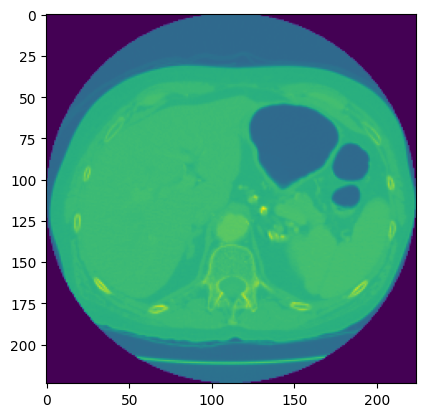

In [5]:
plt.imshow(images[0])

In [6]:
# Normalization
images = images/255.0

In [7]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)

# Print the mapping of labels to their encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)


Label Mapping: {'benign': 0, 'malignant': 1}


In [8]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.3, random_state=42, shuffle=True)

# Convert to numpy arrays and reshape
X_train = np.array(X_train).reshape(-1, 224, 224, 1)
X_test = np.array(X_test).reshape(-1, 224, 224, 1)

# Define number of classes
num_classes = len(np.unique(labels_encoded))

print(num_classes)

2


In [16]:
import cv2
import numpy as np

# Function to resize the images to 299x299x1
def resize_images(images, new_size=(299, 299)):
    resized_images = []
    for image in images:
        resized = cv2.resize(image, new_size)  # Resize to 299x299
        resized = np.expand_dims(resized, axis=-1)  # Add the channel dimension
        resized_images.append(resized)
    return np.array(resized_images)

# Resize X_train and X_test
X_train_resized = resize_images(X_train, new_size=(299, 299))
X_test_resized = resize_images(X_test, new_size=(299, 299))

print(f"Resized X_train shape: {X_train_resized.shape}")
print(f"Resized X_test shape: {X_test_resized.shape}")

Resized X_train shape: (7000, 299, 299, 1)
Resized X_test shape: (3000, 299, 299, 1)


# VGG-19

In [9]:
import tensorflow as tf

input_shape = (224, 224, 1)  # Input shape for grayscale images

model5 = tf.keras.Sequential([
    # Resizing layer to resize the input images
    tf.keras.layers.Resizing(224, 224, interpolation='bilinear', input_shape=input_shape),
    
    # Block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 4
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 5
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Classification head
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model5.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the path where the model with the best parameters will be saved
checkpoint_path = "best_model.keras"

# Create a callback that saves the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,
    mode='max',  # Save when val_accuracy is maximized
    verbose=1
)

# Create an EarlyStopping callback with patience=5
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=10,  # Stop training if no improvement after 10 epochs
    mode='max',  # Check for maximization of val_accuracy
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best validation accuracy
)

# Train the model with the checkpoint and early stopping callbacks
history5 = model5.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=16,
                    callbacks=[checkpoint_callback, early_stopping_callback])


Epoch 1/50


I0000 00:00:1728929471.649231     131 service.cc:145] XLA service 0x7aff380204e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728929471.649284     131 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728929471.649288     131 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728929498.754978     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.6561 - loss: 0.6565
Epoch 1: val_accuracy improved from -inf to 0.65071, saving model to best_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 145s 322ms/step - accuracy: 0.6561 - loss: 0.6565 - val_accuracy: 0.6507 - val_loss: 0.6473
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6475 - loss: 0.6490
Epoch 2: val_accuracy improved from 0.65071 to 0.73643, saving model to best_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 111s 317ms/step - accuracy: 0.6476 - loss: 0.6490 - val_accuracy: 0.7364 - val_loss: 0.5453
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.7564 - loss: 0.5070
Epoch 3: val_accuracy improved from 0.73643 to 0.87500, saving model to best_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 111s 317ms/step - accuracy: 0.7566 - loss: 0.5068 - val_accuracy: 0.8750 - val_loss: 0.3083
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9232 - loss: 0.1921
Epoch 4: val_accuracy improved f

# ResNet-50

In [13]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Saving the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First layer
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second layer
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value here, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X
def ResNet50(input_shape=(64, 64, 1), classes=2):
    """
    Implementation of the ResNet50 architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

model4 = ResNet50(input_shape=(224, 224, 1), classes=2)

In [14]:
model4.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the path where the model with the best parameters will be saved
checkpoint_path = "best_model.keras"

# Create a callback that saves the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,
    mode='max',  # Save when val_accuracy is maximized
    verbose=1
)

# Create an EarlyStopping callback with patience=5
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=10,  # Stop training if no improvement after 10 epochs
    mode='max',  # Check for maximization of val_accuracy
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best validation accuracy
)

# Train the model with the checkpoint and early stopping callbacks
history4 = model4.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[checkpoint_callback, early_stopping_callback])


Epoch 1/50


I0000 00:00:1728933824.326218     132 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_28', 20 bytes spill stores, 20 bytes spill loads



175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6763 - loss: 1.0389
Epoch 1: val_accuracy improved from -inf to 0.36286, saving model to best_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 115s 346ms/step - accuracy: 0.6765 - loss: 1.0379 - val_accuracy: 0.3629 - val_loss: 0.8533
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8190 - loss: 0.5461
Epoch 2: val_accuracy improved from 0.36286 to 0.52429, saving model to best_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 53s 301ms/step - accuracy: 0.8192 - loss: 0.5458 - val_accuracy: 0.5243 - val_loss: 0.8495
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9236 - loss: 0.2596
Epoch 3: val_accuracy improved from 0.52429 to 0.94786, saving model to best_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 53s 301ms/step - accuracy: 0.9237 - loss: 0.2596 - val_accuracy: 0.9479 - val_loss: 0.5295
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9461 - loss: 0.2658
Epoch 4: val_accuracy improved fro

# Inception V3

In [17]:
# Define inception module function
def inception_module(x, f1, f2, f3):
    conv1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)
    conv3 = Conv2D(f2, (3, 3), padding='same', activation='relu')(x)
    conv5 = Conv2D(f3, (5, 5), padding='same', activation='relu')(x)
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    out = concatenate([conv1, conv3, conv5, pool], axis=channel_axis)
    return out
# Define conv2d_bn function
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1)):
    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=channel_axis, scale=False)(x)
    x = Activation('relu')(x)
    return x
# Define inception and reduction blocks
def inc_block_a(x):
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=channel_axis)
    return x
def reduction_block_a(x):
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate([branch3x3, branch3x3dbl, branch_pool], axis=channel_axis)
    return x


def inc_block_b(x):
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool], axis=channel_axis)
    return x
def reduction_block_b(x):
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3, strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate([branch3x3, branch7x7x3, branch_pool], axis=channel_axis)
    return x

def inc_block_c(x):
    branch1x1 = conv2d_bn(x, 320, 1, 1)

    branch3x3 = conv2d_bn(x, 384, 1, 1)
    branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
    branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
    branch3x3 = concatenate([branch3x3_1, branch3x3_2], axis=channel_axis)

    branch3x3dbl = conv2d_bn(x, 448, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
    branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
    branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
    branch3x3dbl = concatenate([branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate([branch1x1, branch3x3, branch3x3dbl, branch_pool], axis=channel_axis)
    return x


img_input = Input(shape=(299, 299, 1))  # Grayscale images
channel_axis = -1 
x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')  # 149 x 149 x 32
x = conv2d_bn(x, 32, 3, 3, padding='valid')  # 147 x 147 x 32
x = conv2d_bn(x, 64, 3, 3)  # 147 x 147 x 64

x = MaxPooling2D((3, 3), strides=(2, 2))(x)  # 73 x 73 x 64
x = conv2d_bn(x, 80, 1, 1, padding='valid')  # 73 x 73 x 80
x = conv2d_bn(x, 192, 3, 3, padding='valid')  # 71 x 71 x 192
x = MaxPooling2D((3, 3), strides=(2, 2))(x)  # 35 x 35 x 192

x = inc_block_a(x)  # 35 x 35 x 256
x = inc_block_a(x)  # 35 x 35 x 256
x = inc_block_a(x)  # 35 x 35 x 256

x = reduction_block_a(x)  # 17 x 17 x 736

x = inc_block_b(x)  # 17 x 17 x 768
x = inc_block_b(x)  # 17 x 17 x 768
x = inc_block_b(x)  # 17 x 17 x 768
x = inc_block_b(x)  # 17 x 17 x 768

x = reduction_block_b(x)  # 8 x 8 x 1280

x = inc_block_c(x)  # 8 x 8 x 2048
x = inc_block_c(x)  # 8 x 8 x 2048

x = GlobalAveragePooling2D(name='avg_pool')(x)  # shape=(None, 2048)


classes = 2  
x = Dense(classes, activation='softmax', name='predictions')(x)  # shape=(None, 1000)
# Build the model

# Create model
model3 = Model(img_input, x, name='inception_v3')



In [18]:
# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the path where the model with the best parameters will be saved
checkpoint_path = "best_model.keras"

# Create a callback that saves the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,
    mode='max',  # Save when val_accuracy is maximized
    verbose=1
)

# Create an EarlyStopping callback with patience=5
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=10,  # Stop training if no improvement after 5 epochs
    mode='max',  # Check for maximization of val_accuracy
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best validation accuracy
)

# Train the model with the checkpoint and early stopping callbacks
history3 = model3.fit(X_train_resized, y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size=32,
                    callbacks=[checkpoint_callback, early_stopping_callback])


Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.6813 - loss: 0.6242
Epoch 1: val_accuracy improved from -inf to 0.35500, saving model to best_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 175s 496ms/step - accuracy: 0.6818 - loss: 0.6236 - val_accuracy: 0.3550 - val_loss: 1.3108
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9253 - loss: 0.2052
Epoch 2: val_accuracy improved from 0.35500 to 0.42071, saving model to best_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 72s 414ms/step - accuracy: 0.9254 - loss: 0.2049 - val_accuracy: 0.4207 - val_loss: 2.7930
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9795 - loss: 0.0652
Epoch 3: val_accuracy improved from 0.42071 to 0.88929, saving model to best_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 72s 412ms/step - accuracy: 0.9795 - loss: 0.0652 - val_accuracy: 0.8893 - val_loss: 0.3317
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9813 - loss: 0.0508
Epoch 4: val_accuracy i

# DesNet-201

In [20]:
def conv_block(x, growth_rate, name):
    """A building block for a dense block."""
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(x)
    x1 = Activation('relu', name=name + '_0_relu')(x1)
    x1 = Conv2D(4 * growth_rate, 1, use_bias=False, name=name + '_1_conv')(x1)
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x1)
    x1 = Activation('relu', name=name + '_1_relu')(x1)
    x1 = Conv2D(growth_rate, 3, padding='same', use_bias=False, name=name + '_2_conv')(x1)
    x = concatenate([x, x1], axis=bn_axis, name=name + '_concat')
    return x

def transition_block(x, reduction, name):
    """A transition block."""
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_bn')(x)
    x = Activation('relu', name=name + '_relu')(x)
    x = Conv2D(int(tf.keras.backend.int_shape(x)[bn_axis] * reduction), 1, use_bias=False, name=name + '_conv')(x)
    x = AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x

def dense_block(x, blocks, name):
    """A dense block."""
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x

def DenseNet201(input_shape=None, classes=2):
    """Instantiates the DenseNet-201 architecture."""
    img_input = Input(shape=input_shape)

    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1

    x = ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
    x = Conv2D(64, 7, strides=2, use_bias=False, name='conv1_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = MaxPooling2D(3, strides=2, name='pool1')(x)

    x = dense_block(x, 6, name='conv2')
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, 12, name='conv3')
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, 48, name='conv4')
    x = transition_block(x, 0.5, name='pool4')
    x = dense_block(x, 32, name='conv5')

    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = Activation('relu', name='relu')(x)

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(classes, activation='softmax', name='fc')(x)

    # Create model.
    model = Model(img_input, x, name='densenet201')

    return model

# Example usage:
model1 = DenseNet201(input_shape=(224, 224, 1), classes=2)


In [21]:
# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the path where the model with the best parameters will be saved
checkpoint_path = "best_model.keras"

# Create a callback that saves the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,
    mode='max',  # Save when val_accuracy is maximized
    verbose=1
)

# Create an EarlyStopping callback with patience=5
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=10,  # Stop training if no improvement after 10 epochs
    mode='max',  # Check for maximization of val_accuracy
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best validation accuracy
)

# Train the model with the checkpoint and early stopping callbacks
history1 = model1.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size=16,
                    callbacks=[checkpoint_callback, early_stopping_callback])


Epoch 1/50


I0000 00:00:1728938446.910787     130 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_48', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_49', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_slice_fusion_1', 8 bytes spill stores, 8 bytes spill loads



350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6967 - loss: 0.6248
Epoch 1: val_accuracy improved from -inf to 0.68500, saving model to best_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 390s 360ms/step - accuracy: 0.6970 - loss: 0.6243 - val_accuracy: 0.6850 - val_loss: 1.2700
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9481 - loss: 0.1380
Epoch 2: val_accuracy improved from 0.68500 to 0.93214, saving model to best_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 96s 274ms/step - accuracy: 0.9481 - loss: 0.1379 - val_accuracy: 0.9321 - val_loss: 0.4551
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9675 - loss: 0.0928
Epoch 3: val_accuracy improved from 0.93214 to 0.96071, saving model to best_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 98s 279ms/step - accuracy: 0.9675 - loss: 0.0927 - val_accuracy: 0.9607 - val_loss: 1.0196
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9864 - loss: 0.0417
Epoch 4: val_accuracy did not impr

# EfficientNet-B2

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


# Load the EfficientNet B2 model with random weights
base_model = EfficientNetB2(weights=None, include_top=False, input_shape=(224, 224, 1))

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a fully connected dense layer with 1024 units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add a dropout layer for regularization
x = tf.keras.layers.Dropout(0.5)(x)

# Add the output layer for 2 classes
output = Dense(2, activation='softmax')(x)

# Create the final model
model2 = Model(inputs=base_model.input, outputs=output)


In [24]:
# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the path where the model with the best parameters will be saved
checkpoint_path = "best_model.keras"

# Create a callback that saves the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,
    mode='max',  # Save when val_accuracy is maximized
    verbose=1
)

# Create an EarlyStopping callback with patience=5
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=10,  # Stop training if no improvement after 10 epochs
    mode='max',  # Check for maximization of val_accuracy
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best validation accuracy
)

# Train the model with the checkpoint and early stopping callbacks
history2 = model2.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size=16,
                    callbacks=[checkpoint_callback, early_stopping_callback])


Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6024 - loss: 0.8818
Epoch 1: val_accuracy improved from -inf to 0.65071, saving model to best_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 196s 154ms/step - accuracy: 0.6024 - loss: 0.8814 - val_accuracy: 0.6507 - val_loss: 0.6516
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7752 - loss: 0.4663
Epoch 2: val_accuracy improved from 0.65071 to 0.90000, saving model to best_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.7755 - loss: 0.4659 - val_accuracy: 0.9000 - val_loss: 0.2972
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9713 - loss: 0.0991
Epoch 3: val_accuracy improved from 0.90000 to 0.97286, saving model to best_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - accuracy: 0.9713 - loss: 0.0990 - val_accuracy: 0.9729 - val_loss: 0.0866
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9903 - loss: 0.0335
Epoch 4: val_accuracy im

# Visualization

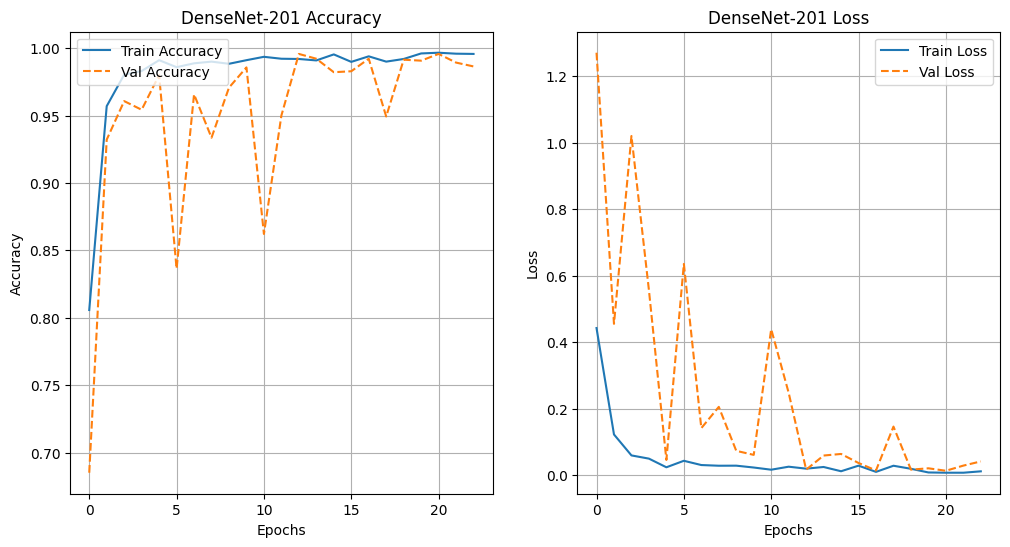

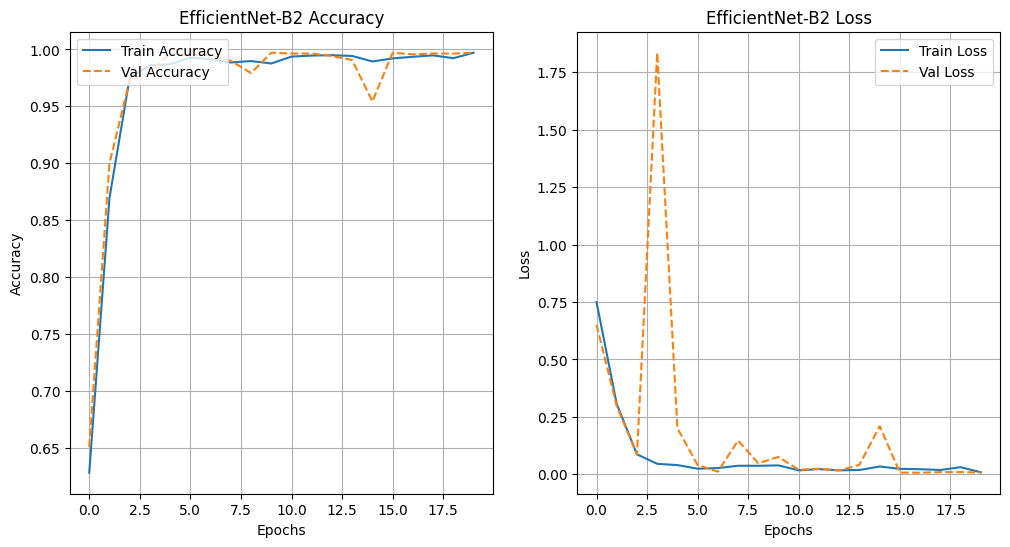

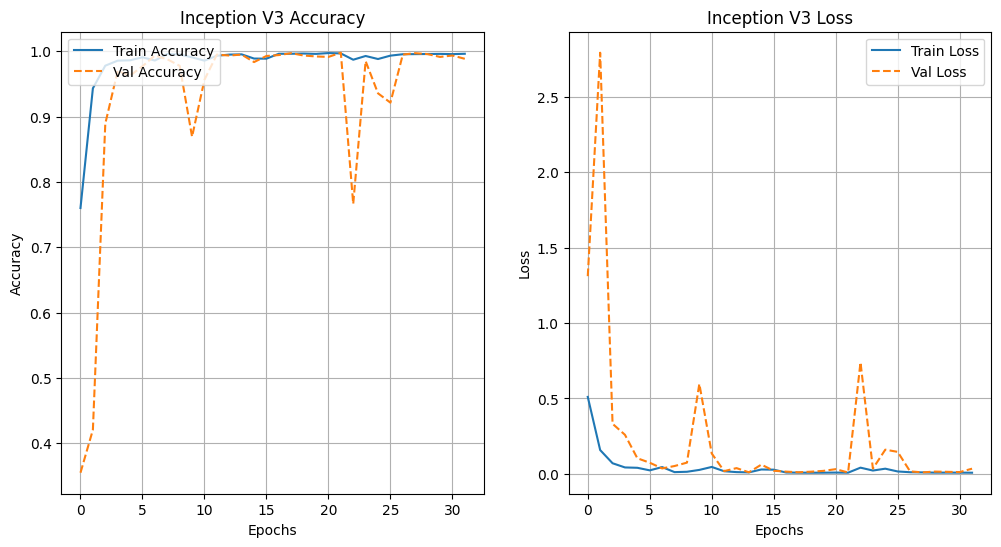

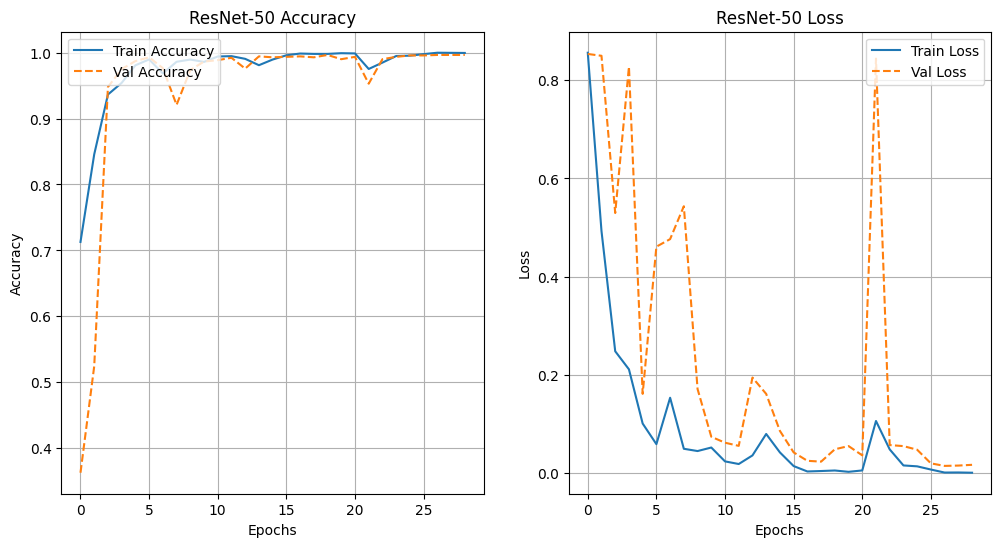

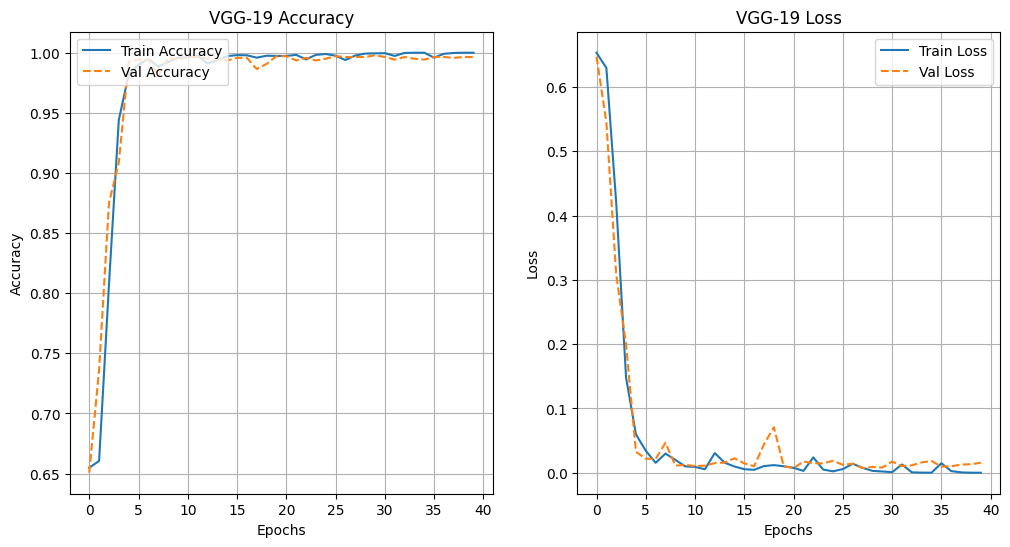

In [30]:
import matplotlib.pyplot as plt

# Plotting for DenseNet-201 (Model 1)
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('DenseNet-201 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('DenseNet-201 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

# Plotting for EfficientNet-B2 (Model 2)
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('EfficientNet-B2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('EfficientNet-B2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

# Plotting for Inception V3 (Model 3)
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('Inception V3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('Inception V3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

# Plotting for ResNet-50 (Model 4)
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('ResNet-50 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('ResNet-50 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

# Plotting for VGG-19 (Model 5)
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'], label='Train Accuracy')
plt.plot(history5.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('VGG-19 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'], label='Train Loss')
plt.plot(history5.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('VGG-19 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()


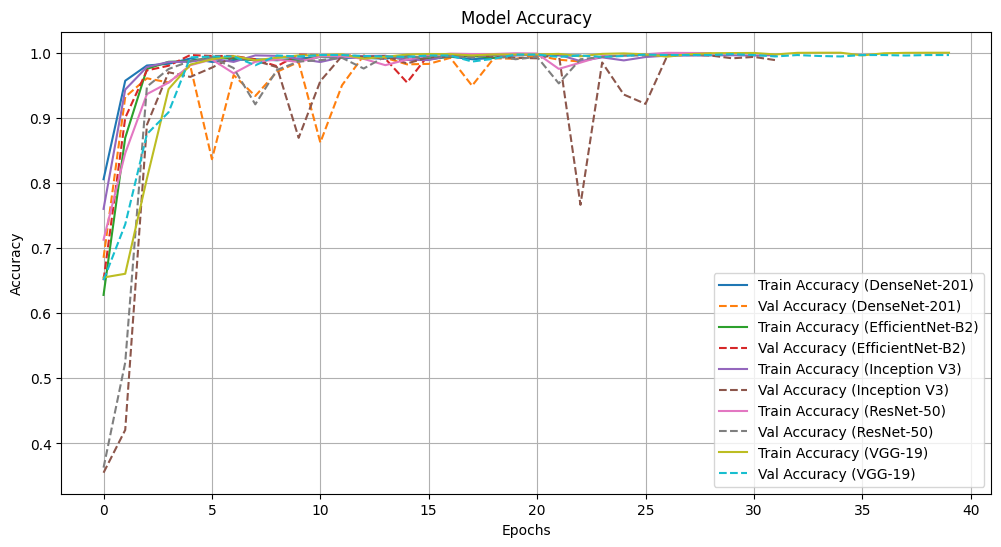

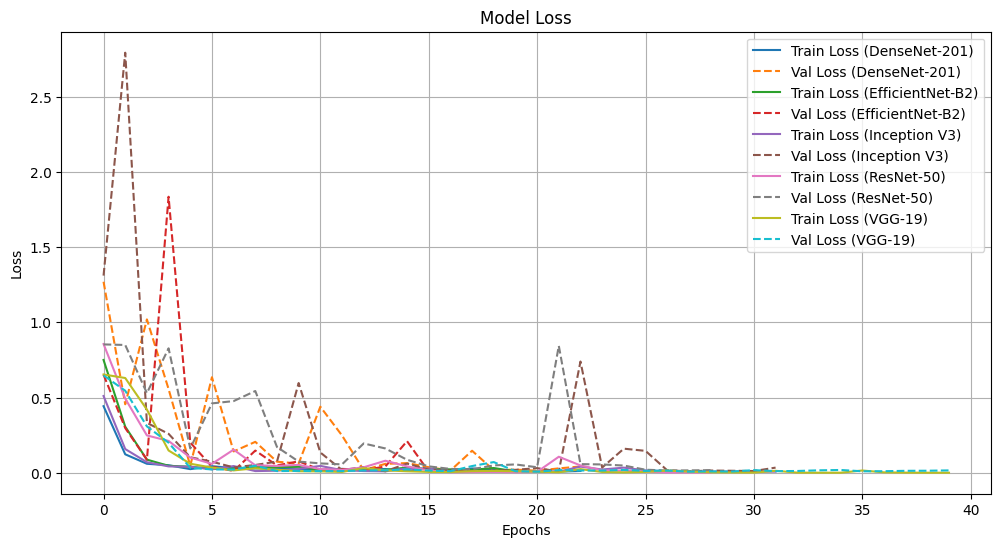

In [31]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy for all models
plt.figure(figsize=(12, 6))

# Model 1
plt.plot(history1.history['accuracy'], label='Train Accuracy (DenseNet-201)')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy (DenseNet-201)', linestyle='--')

# Model 2
plt.plot(history2.history['accuracy'], label='Train Accuracy (EfficientNet-B2)')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy (EfficientNet-B2)', linestyle='--')

# Model 3
plt.plot(history3.history['accuracy'], label='Train Accuracy (Inception V3)')
plt.plot(history3.history['val_accuracy'], label='Val Accuracy (Inception V3)', linestyle='--')

# Model 4
plt.plot(history4.history['accuracy'], label='Train Accuracy (ResNet-50)')
plt.plot(history4.history['val_accuracy'], label='Val Accuracy (ResNet-50)', linestyle='--')

# Model 5
plt.plot(history5.history['accuracy'], label='Train Accuracy (VGG-19)')
plt.plot(history5.history['val_accuracy'], label='Val Accuracy (VGG-19)', linestyle='--')

plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot training and validation loss for all models
plt.figure(figsize=(12, 6))

# Model 1
plt.plot(history1.history['loss'], label='Train Loss (DenseNet-201)')
plt.plot(history1.history['val_loss'], label='Val Loss (DenseNet-201)', linestyle='--')

# Model 2
plt.plot(history2.history['loss'], label='Train Loss (EfficientNet-B2)')
plt.plot(history2.history['val_loss'], label='Val Loss (EfficientNet-B2)', linestyle='--')

# Model 3
plt.plot(history3.history['loss'], label='Train Loss (Inception V3)')
plt.plot(history3.history['val_loss'], label='Val Loss (Inception V3)', linestyle='--')

# Model 4
plt.plot(history4.history['loss'], label='Train Loss (ResNet-50)')
plt.plot(history4.history['val_loss'], label='Val Loss (ResNet-50)', linestyle='--')

# Model 5
plt.plot(history5.history['loss'], label='Train Loss (VGG-19)')
plt.plot(history5.history['val_loss'], label='Val Loss (VGG-19)', linestyle='--')

plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [36]:
# Function to calculate specificity and sensitivity
def specificity_score(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    return specificity, sensitivity

# Function to print the metrics for each model with updated confusion matrix
def print_model_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Confusion matrix with labels
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[1, 0])  # Malignant = 1, Benign = 0
    specificity, sensitivity = specificity_score(conf_matrix)
    
    # Print metrics
    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Malignant', 'Benign'], yticklabels=['Malignant', 'Benign'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()


94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step
Metrics for DenseNet-201:
Accuracy: 0.9960
Precision: 0.9960
Recall: 0.9960
F1 Score: 0.9960
Specificity: 0.9990
Sensitivity: 0.9907


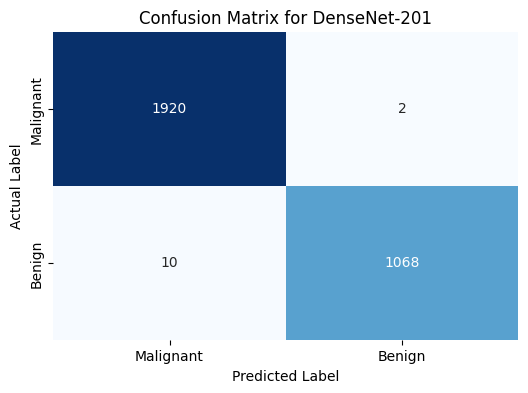

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step
Metrics for EfficientNet-B2:
Accuracy: 0.9970
Precision: 0.9970
Recall: 0.9970
F1 Score: 0.9970
Specificity: 0.9995
Sensitivity: 0.9926


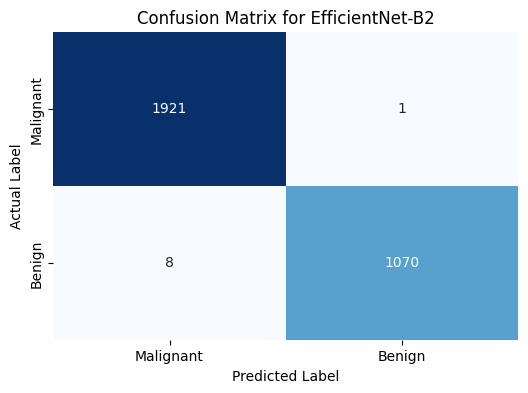

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step
Metrics for Inception V3:
Accuracy: 0.9963
Precision: 0.9963
Recall: 0.9963
F1 Score: 0.9963
Specificity: 0.9984
Sensitivity: 0.9926


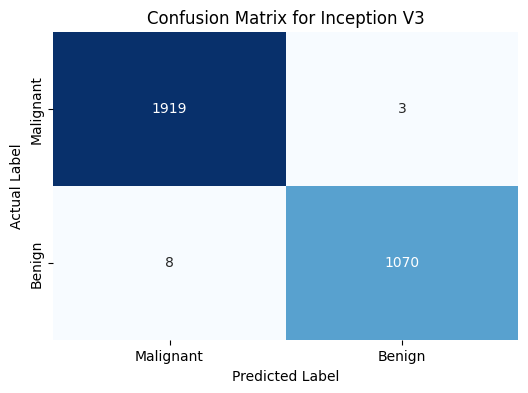

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step
Metrics for ResNet-50:
Accuracy: 0.9960
Precision: 0.9960
Recall: 0.9960
F1 Score: 0.9960
Specificity: 0.9990
Sensitivity: 0.9907


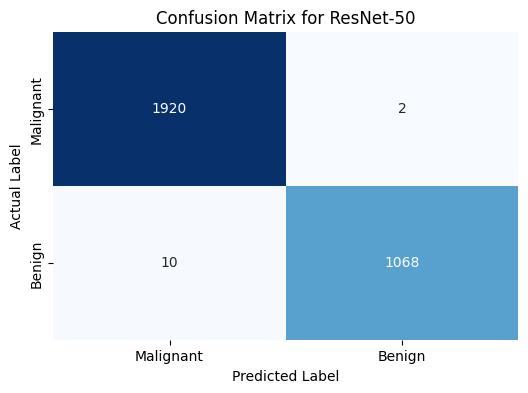

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step
Metrics for VGG-19:
Accuracy: 0.9933
Precision: 0.9933
Recall: 0.9933
F1 Score: 0.9933
Specificity: 0.9974
Sensitivity: 0.9861


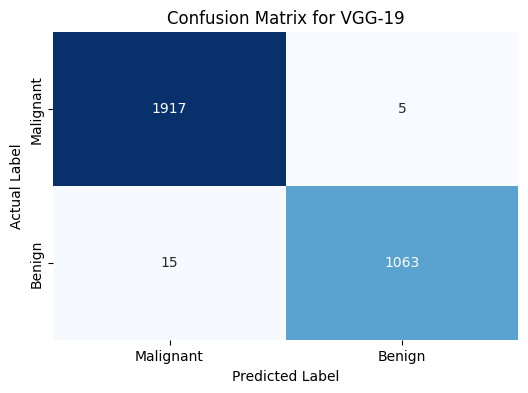

In [37]:
# For DenseNet-201 (Model 1)
y_pred1 = np.argmax(model1.predict(X_test), axis=1)
y_true1 = np.argmax(y_test, axis=1)
print_model_metrics(y_true1, y_pred1, 'DenseNet-201')

# For EfficientNet-B2 (Model 2)
y_pred2 = np.argmax(model2.predict(X_test), axis=1)
y_true2 = np.argmax(y_test, axis=1)
print_model_metrics(y_true2, y_pred2, 'EfficientNet-B2')

# For Inception V3 (Model 3)
y_pred3 = np.argmax(model3.predict(X_test_resized), axis=1)
y_true3 = np.argmax(y_test, axis=1)
print_model_metrics(y_true3, y_pred3, 'Inception V3')

# For ResNet-50 (Model 4)
y_pred4 = np.argmax(model4.predict(X_test), axis=1)
y_true4 = np.argmax(y_test, axis=1)
print_model_metrics(y_true4, y_pred4, 'ResNet-50')

# For VGG-19 (Model 5)
y_pred5 = np.argmax(model5.predict(X_test), axis=1)
y_true5 = np.argmax(y_test, axis=1)
print_model_metrics(y_true5, y_pred5, 'VGG-19')

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step


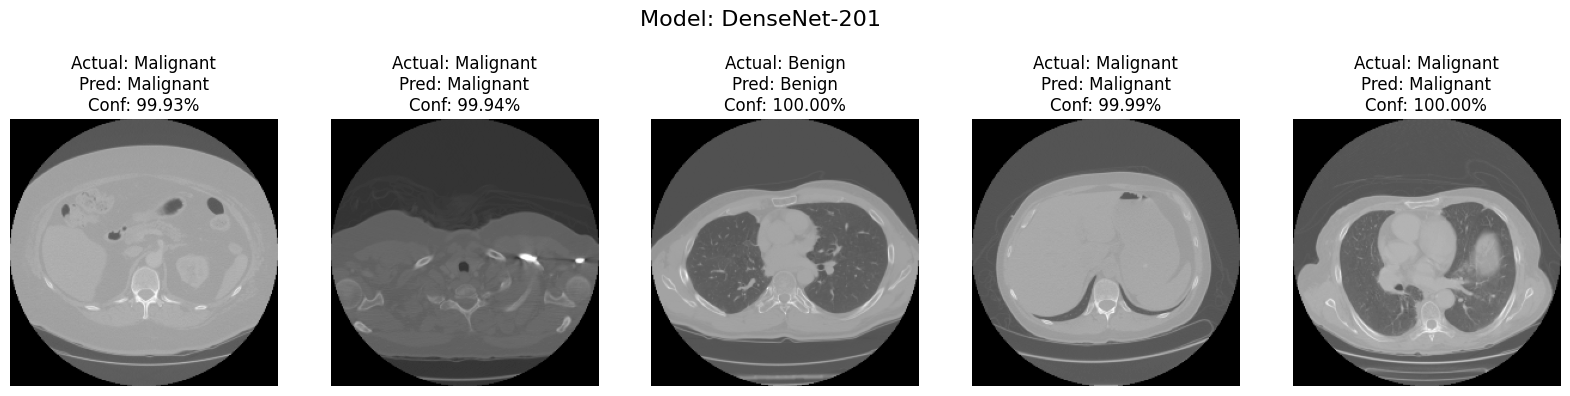

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


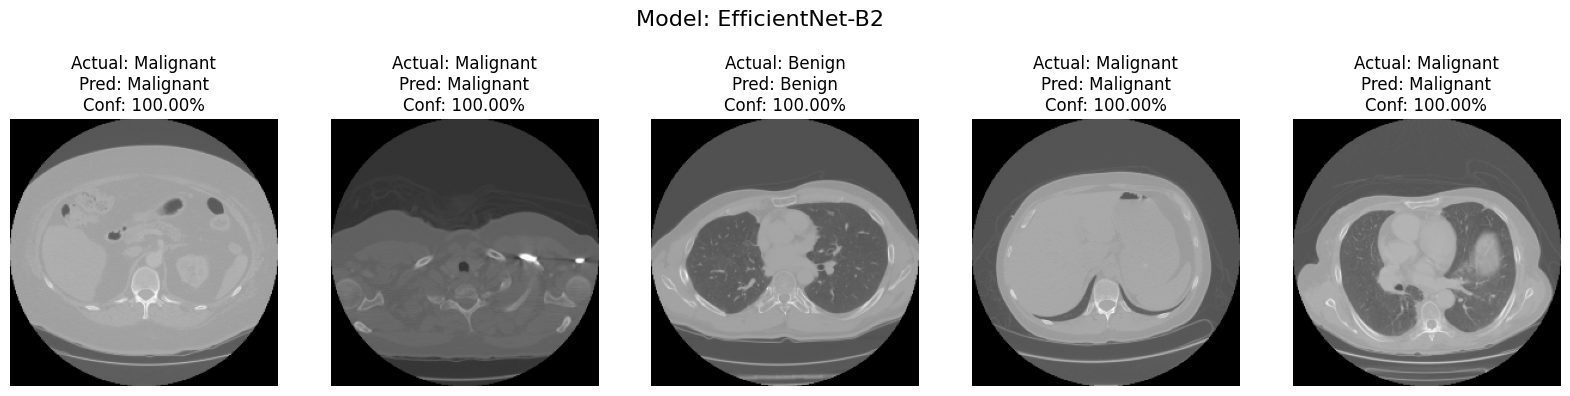

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step


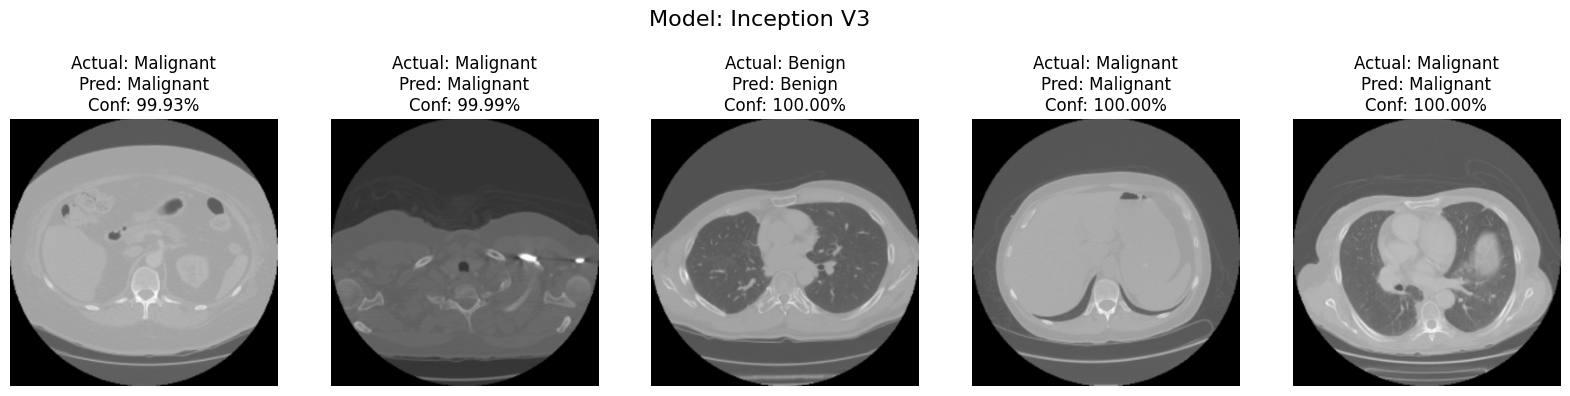

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step


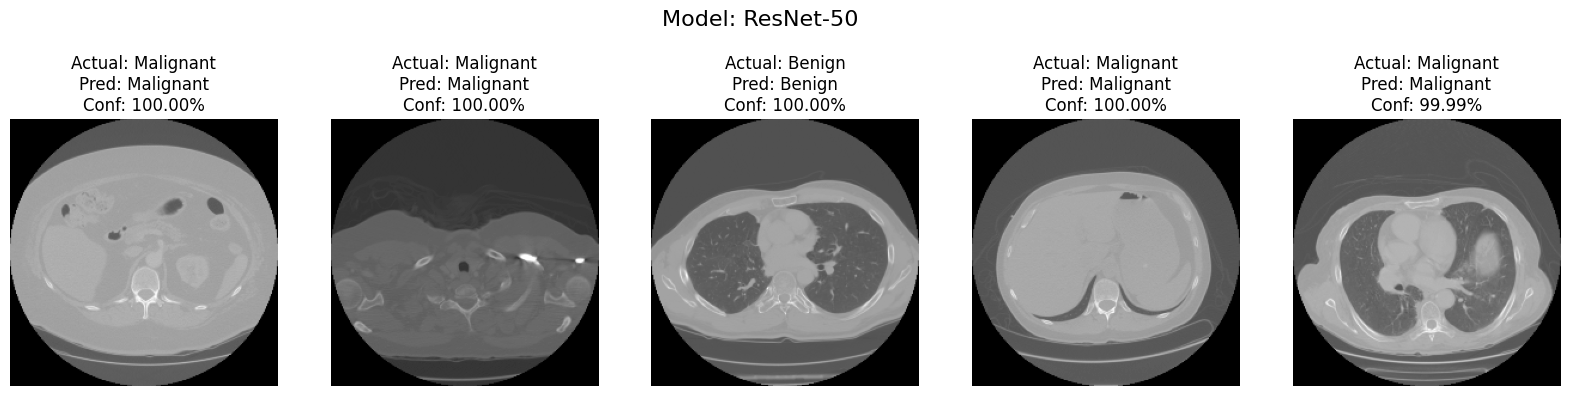

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step


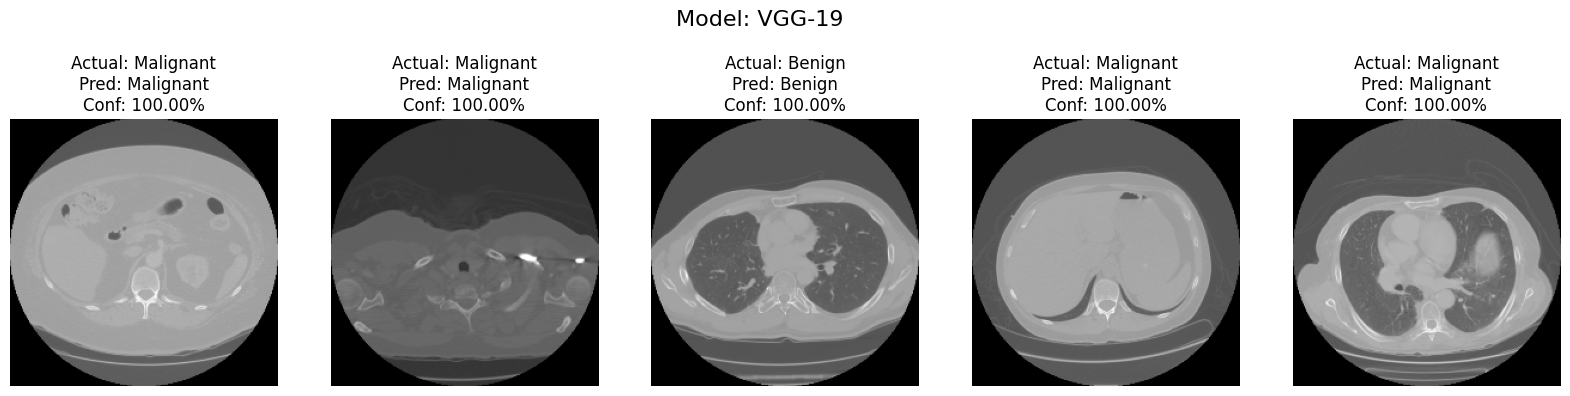

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to display images in one row with actual and predicted labels along with confidence scores
def plot_images_row(X, y_true, y_pred, y_prob, indices, model_name, img_size):
    plt.figure(figsize=(20, 5))
    
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(X[idx].reshape(img_size, img_size), cmap='gray')  # Assuming grayscale images
        
        # Get actual and predicted labels
        actual_label = 'Malignant' if y_true[idx] == 1 else 'Benign'
        predicted_label = 'Malignant' if y_pred[idx] == 1 else 'Benign'
        confidence_score = y_prob[idx][y_pred[idx]] * 100  # Confidence score for the predicted class
        
        # Set title with actual, predicted labels and confidence
        plt.title(f"Actual: {actual_label}\nPred: {predicted_label}\nConf: {confidence_score:.2f}%")
        plt.axis('off')
    
    plt.suptitle(f'Model: {model_name}', fontsize=16)
    plt.show()

# Function to predict and plot 5 images in one row for each model
def make_predictions_and_plot_row(model, X_test, y_test, model_name, img_size=224, indices=None):
    y_prob = model.predict(X_test)  # Predicted probabilities
    y_pred = np.argmax(y_prob, axis=1)  # Predicted class labels
    y_true = np.argmax(y_test, axis=1)  # Actual class labels

    plot_images_row(X_test, y_true, y_pred, y_prob, indices, model_name, img_size)

# Randomly select 'n_samples' images to plot once and use the same images for all models
n_samples = 5
indices = random.sample(range(len(X_test)), n_samples)

# Call the function for each model with the same 5 images in one row

# For DenseNet-201 (Model 1)
make_predictions_and_plot_row(model1, X_test, y_test, 'DenseNet-201', indices=indices)

# For EfficientNet-B2 (Model 2)
make_predictions_and_plot_row(model2, X_test, y_test, 'EfficientNet-B2', indices=indices)

# For Inception V3 (Model 3)
make_predictions_and_plot_row(model3, X_test_resized, y_test, 'Inception V3', img_size=299, indices=indices)  # For InceptionV3, image size is 299x299

# For ResNet-50 (Model 4)
make_predictions_and_plot_row(model4, X_test, y_test, 'ResNet-50', indices=indices)

# For VGG-19 (Model 5)
make_predictions_and_plot_row(model5, X_test, y_test, 'VGG-19', indices=indices)


In [43]:
model1.save('/kaggle/working/DenseNet-201.keras')
model2.save('/kaggle/working/EfficentB2.keras')
model3.save('/kaggle/working/InceptionV3.keras')
model4.save('/kaggle/working/ResNet50.keras')
model5.save('/kaggle/working/VGG19.keras')